<p style="border: 1px solid #e7692c; border-left: 15px solid #e7692c; padding: 10px; text-align:justify;">
    <strong style="color: #e7692c">Tip.</strong> <a style="color: #000000;" href="https://nbviewer.jupyter.org/github/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/blob/master/Chapter07/ch7_nb1_set_up_efficient_input_pipelines_with_tf_data.ipynb" title="View with Jupyter Online">Click here to view this notebook on <code>nbviewer.jupyter.org</code></a>. 
    <br/>These notebooks are better read there, as Github default viewer ignores some of the formatting and interactive content.
    </p>

<table style="font-size: 1em; padding: 0; margin: 0;">
    <tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #363636; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #e7692c;">Hands-on</span> Computer Vision with TensorFlow 2</span><br/>by <em>Eliot Andres</em> & <em>Benjamin Planche</em> (Packt Pub.)</strong><br/><br/>
        <strong>> Chapter 7: Training on Complex and Scarce Datasets</strong><br/>
    </p>

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #e7692c;">
    Notebook 1:</small><br/>Setting up Efficient Input Pipelines<br/>with <code style="background: none;">tf.data</code></h1>
<br/>
<p style="border-left: 15px solid #363636; text-align:justify; padding: 0 10px;">
    Chapter 7 is dedicated to data preparation for deep learning. Therefore, in this first notebook, we will finally properly introduce the <strong><code>tf.data</code></strong> API. 
    <br/><br/>
    We will detail the different components of the input pipelines we used so far, and demonstrate how to <strong>optimize</strong> them further for smoother trainings.
</p>
<br/>
<p style="border-left: 15px solid #e7692c; padding: 0 10px; text-align:justify;">
    <strong style="color: #e7692c;">Tip.</strong> The notebooks shared on this git repository illustrate some notions from the book "<em><strong>Hands-on Computer Vision with TensorFlow 2</strong></em>" written by Eliot Andres and Benjamin Planche, published by Packt. If you enjoyed the insights shared here, <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!"><strong>please consider acquiring the book!</strong></a>
<br/><br/>
The book provides further guidance for those eager to learn about computer vision and to harness the power of TensorFlow 2 and Keras to build efficient recognition systems for object detection, segmentation, video processing, smartphone applications, and more.</p>
        </td>
        <td style="vertical-align: top; padding: 0; margin: 0; width: 280px;">
    <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!" target="_blank">
        <img src="../banner_images/book_cover.png" width=280>
    </a>
    <p style="background: #e7692c; color:#ffffff; padding: 10px; text-align:justify;"><strong>Leverage deep learning to create powerful image processing apps with TensorFlow 2 and Keras. <br/></strong>Get the book for more insights!</p>
    <ul style="height: 32px; white-space: nowrap; text-align: center; margin: 0px; padding: 0px; padding-top: 10px;">
    <li style="display: block;height: 100%;float: left;vertical-align: middle;margin: 0 25px 10px;padding: 0px;">
        <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Get the book on Amazon (paperback or Kindle version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_amazon.png" width="75px">
        </a>
    </li>
    <li style="display: inline-block;height: 100%;vertical-align: middle;float: right;margin: -5px 25px 10px;padding: 0px;">
        <a href="https://www.packtpub.com/application-development/hands-computer-vision-tensorflow-2" title="Get your Packt book (paperback, PDF, ePUB, or MOBI version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_packt.png" width="75px">
        </a>
    </li>
    </ul>
        </td>
        </tr>
        </table>

In [14]:
import os
import numpy as np
import tensorflow as tf

# Seeding the PRNGs:
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

os.environ["CUDA_VISIBLE_DEVICES"]= "1"

## Preparing Input Pipelines for Complex Applications

As we discussed in the chapter, data is the life and blood of machine learning systems, and setting up efficient tools to process, visualize, and stream samples from the target datasets should be the priority when starting new projects. This becomes even more crucial for applications with complex input and/or target data (framented/heterogeneous datasets, multi-dimensional label maps, etc.). 

In the following section, we will go back to the semantic segmentation application for autonomous driving we presented in the Chapter [6](../ch6), and detail step by step the operations the _Cityscapes_[$^1$](#ref) data samples undergo before reaching the model to train.

**Note:** We will reuse some of the utility methods implemented in Notebook [6-4](../Chapter06/ch6_nb4_data_preparation_for_smart_car_apps.ipynb):

In [15]:
from cityscapes_utils import (
    CITYSCAPES_FOLDER, # change this variable to Cityscapes root folder
    CITYSCAPES_LABELS, CITYSCAPES_IGNORE_VALUE, 
    get_cityscapes_file_pairs,
    postprocess_to_show, change_ratio)

from plot_utils import plot_image_grid

batch_size     = 32
num_epochs     = 90
image_size     = [256, 256]
num_channels   = 3
num_classes    = len(CITYSCAPES_LABELS)
num_show       = 3

### Extracting Data

Considering input pipelines for CNNs as ETL processes, the first step consists of ***extracting the data samples***. For us, it usually means _parsing/listing the files_ containing the images and corresponding labels for the training and validation data:

In [16]:
train_input_files, train_gt_files = get_cityscapes_file_pairs(
    split='train', type='leftImg8bit_blurred')
val_input_files, val_gt_files = get_cityscapes_file_pairs(
    split='val', type='leftImg8bit_blurred')

print("Cityscapes - Training Dataset : {} images ; {} GTs.".format(
    len(train_input_files), len(train_gt_files)))
print("Cityscapes - Validation Dataset : {} images ; {} GTs.".format(
    len(val_input_files), len(val_gt_files)))

Cityscapes - Training Dataset : 2975 images ; 2975 GTs.
Cityscapes - Validation Dataset : 500 images ; 500 GTs.


From these file lists, we can already instantiate `tf.data.Dataset` objects to iterate over them, pair after pair:

In [17]:
# To more easily demonstration some later operations, we build a dataset with a single sample in:
random_image_idx = np.random.choice(len(val_input_files))
image_files = tf.constant([val_input_files[random_image_idx]])
gt_files = tf.constant([val_gt_files[random_image_idx]])

dataset_file = tf.data.Dataset.from_tensor_slices({'image': image_files, 
                                                   'label': gt_files})
# Opt. telling TF to keep iterating over the whole data:
dataset_file = dataset_file.repeat()

print(dataset_file)

<RepeatDataset shapes: {image: (), label: ()}, types: {image: tf.string, label: tf.string}>


### Transforming Data

The second step in ETL pipelines is about ***transforming the data***. A first aspect to consider is, therefore, to parse and convert the data samples to the format expected by the downstream systems. In our case, this means _parsing the files into image/label tensors_, optionally resizing them at the same time.

The following function does exactly that:

In [18]:
def parse_function(filenames, resize_to=[226, 226]):
    """
    Parse files into input/label image pair.
    :param filenames:   Dict containing the two files (filenames['image'], filenames['label'])
    :param resize_to:   H x W Dimensions to resize the image and label to
    :return:            Input tensor, Label tensor
    """

    img_filename, gt_filename = filenames['image'], filenames['label']

    # Reading the files and returning their content as bytes:
    image_string, gt_string = tf.io.read_file(img_filename), tf.io.read_file(gt_filename)
    # Decoding those into images
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)
    gt_decoded = tf.io.decode_png(gt_string, channels=1)

    # Converting image to float:
    image = tf.image.convert_image_dtype(image_decoded, tf.float32)
    gt = tf.cast(gt_decoded, tf.int32)

    # Resizing:
    image = tf.image.resize(image, resize_to)
    gt = tf.image.resize(gt, resize_to, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return image, gt

Purely composed of TensorFlow operations, this function can be assigned to the `tf.data.Dataset` instances using their `.map(fn)` method:

In [19]:
from plot_utils import plot_image_grid
import functools

# We tell the dataset how to parse into images:
parse_fn = functools.partial(parse_function, resize_to=image_size)
dataset_image = dataset_file.map(parse_fn)
print(dataset_image)

<MapDataset shapes: ((256, 256, 3), (256, 256, 1)), types: (tf.float32, tf.int32)>


As we can see, our `tf.data` pipeline now returns two tensors every iteration: the input image and its corresponding label map.

Let us visualie a sample:

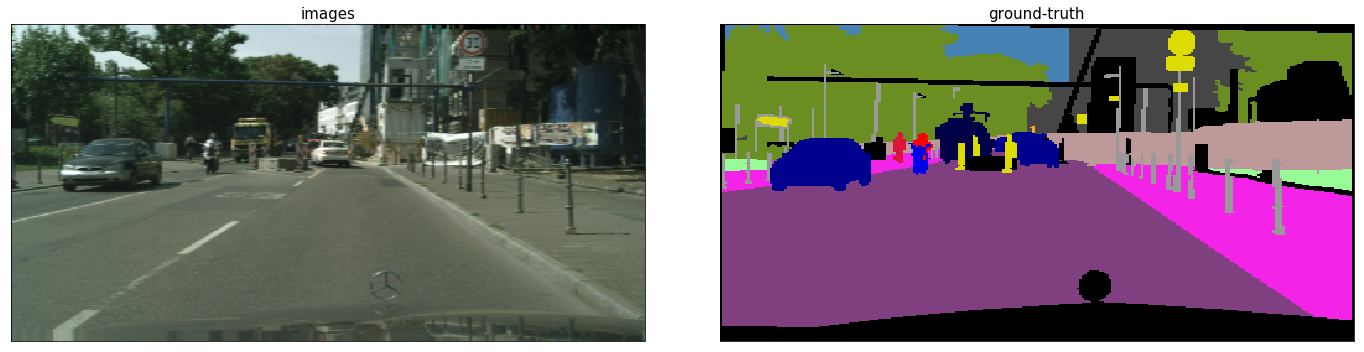

In [20]:
def show_dataset_samples(dataset, num_show=4):
    # We repeat `num_show` time to obtain several augmented version of the same sample.
    # (we assume the data hasn't been batched)
    dataset = dataset.repeat(num_show)
    
    # We iterate to fetch the sample:
    image_show, gt_show = [], []
    for image, gt in dataset:
        image_show.append(image)
        gt_show.append(gt)
        num_show -= 1
        if num_show == 0:
            break

    # We convert and display:
    image_show = tf.stack(image_show, axis=0)
    gt_show = tf.stack(gt_show, axis=0)
    image_show, gt_show = postprocess_to_show(image_show, gt_show)
    figure = plot_image_grid([image_show.numpy(), gt_show.numpy()], 
                             titles=["images", "ground-truth"])
    figure.show()

# Show:
show_dataset_samples(dataset_image, num_show=1)

In many training situations, we may also further transform the samples to ***augment*** them, i.e. applying some relevant random transformations to virtually increase the variability of the training data (c.f. book).

Let us copy and detail the augmentation scheme briefly used as example in the chapter:

In [22]:
def augmentation_function(image, gt_image, 
                          crop_min_factor=None, flip_left_right=True, flip_up_down=False,
                          brightness_max_delta=0.15, saturation_max_delta=0.5):
    """
    Apply random transformations to augment the training images.
    :param images:      Images
    :return:            Augmented Images
    """

    # If we decide to randomly flip or resize/crop the image, the same should be applied to
    # the label one so they still match. Therefore, to simplify the procedure, we stack the
    # two images together along the channel axis, before these random operations:
    do_geometrical_transform = crop_min_factor is not None or flip_left_right or flip_up_down
    if do_geometrical_transform:
        num_image_channels = tf.shape(image)[-1]
        num_gt_channels = tf.shape(gt_image)[-1]
        stacked_images = tf.concat([image, tf.cast(gt_image, dtype=image.dtype)], axis=-1)

        # Randomly applied flip:
        if flip_left_right:
            stacked_images = tf.image.random_flip_left_right(stacked_images)
        if flip_up_down:
            stacked_images = tf.image.random_flip_up_down(stacked_images)

        # Random cropping:
        if crop_min_factor is not None:
            original_shape = tf.shape(stacked_images)[-3:-1]
            random_scale_factor = tf.random.uniform(
                [], minval=crop_min_factor, maxval=1., dtype=tf.float32)
            crop_shape = tf.cast(tf.cast(original_shape, tf.float32) * random_scale_factor, 
                                 tf.int32)
            if len(stacked_images.shape) == 3: # single image:
                crop_shape = tf.concat(
                    [crop_shape, [num_image_channels + num_gt_channels]], axis=0)
            else:                              # batched images:
                batch_size = tf.shape(stacked_images)[0]
                crop_shape = tf.concat(
                    [[batch_size], crop_shape, [num_image_channels + num_gt_channels]], axis=0)
            stacked_images = tf.image.random_crop(stacked_images, crop_shape)

        # The remaining transformations should be applied either differently to the input and GT images
        # (nearest-neighbor resizing for the label image VS interpolated resizing for the image),
        # or only to the input image, not the GT one (color changes, etc.). Therefore, we split them back:
        image = stacked_images[..., :num_image_channels]
        gt_image = tf.cast(stacked_images[..., num_image_channels:], dtype=gt_image.dtype)

        # Resizing back to expected dimensions:
        if crop_min_factor is not None:
            image = tf.image.resize(image, original_shape)
            gt_image = tf.image.resize(gt_image, original_shape, 
                                       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Random B/S changes:
    need_clipping = False
    if brightness_max_delta is not None:
        image = tf.image.random_brightness(image, max_delta=brightness_max_delta)
        need_clipping = True
    if saturation_max_delta is not None:
        image = tf.image.random_saturation(
            image, lower=1 - saturation_max_delta, upper=1 + saturation_max_delta)
        need_clipping = True
    if need_clipping:
        # Because of the random B/S changes, some pixel values may not be in [0, 1] anymore
        # so we clip them properly.
        image = tf.clip_by_value(image, 0.0, 1.0)

    return image, gt_image


As we did before, we can assign this additional function to our input pipelines:

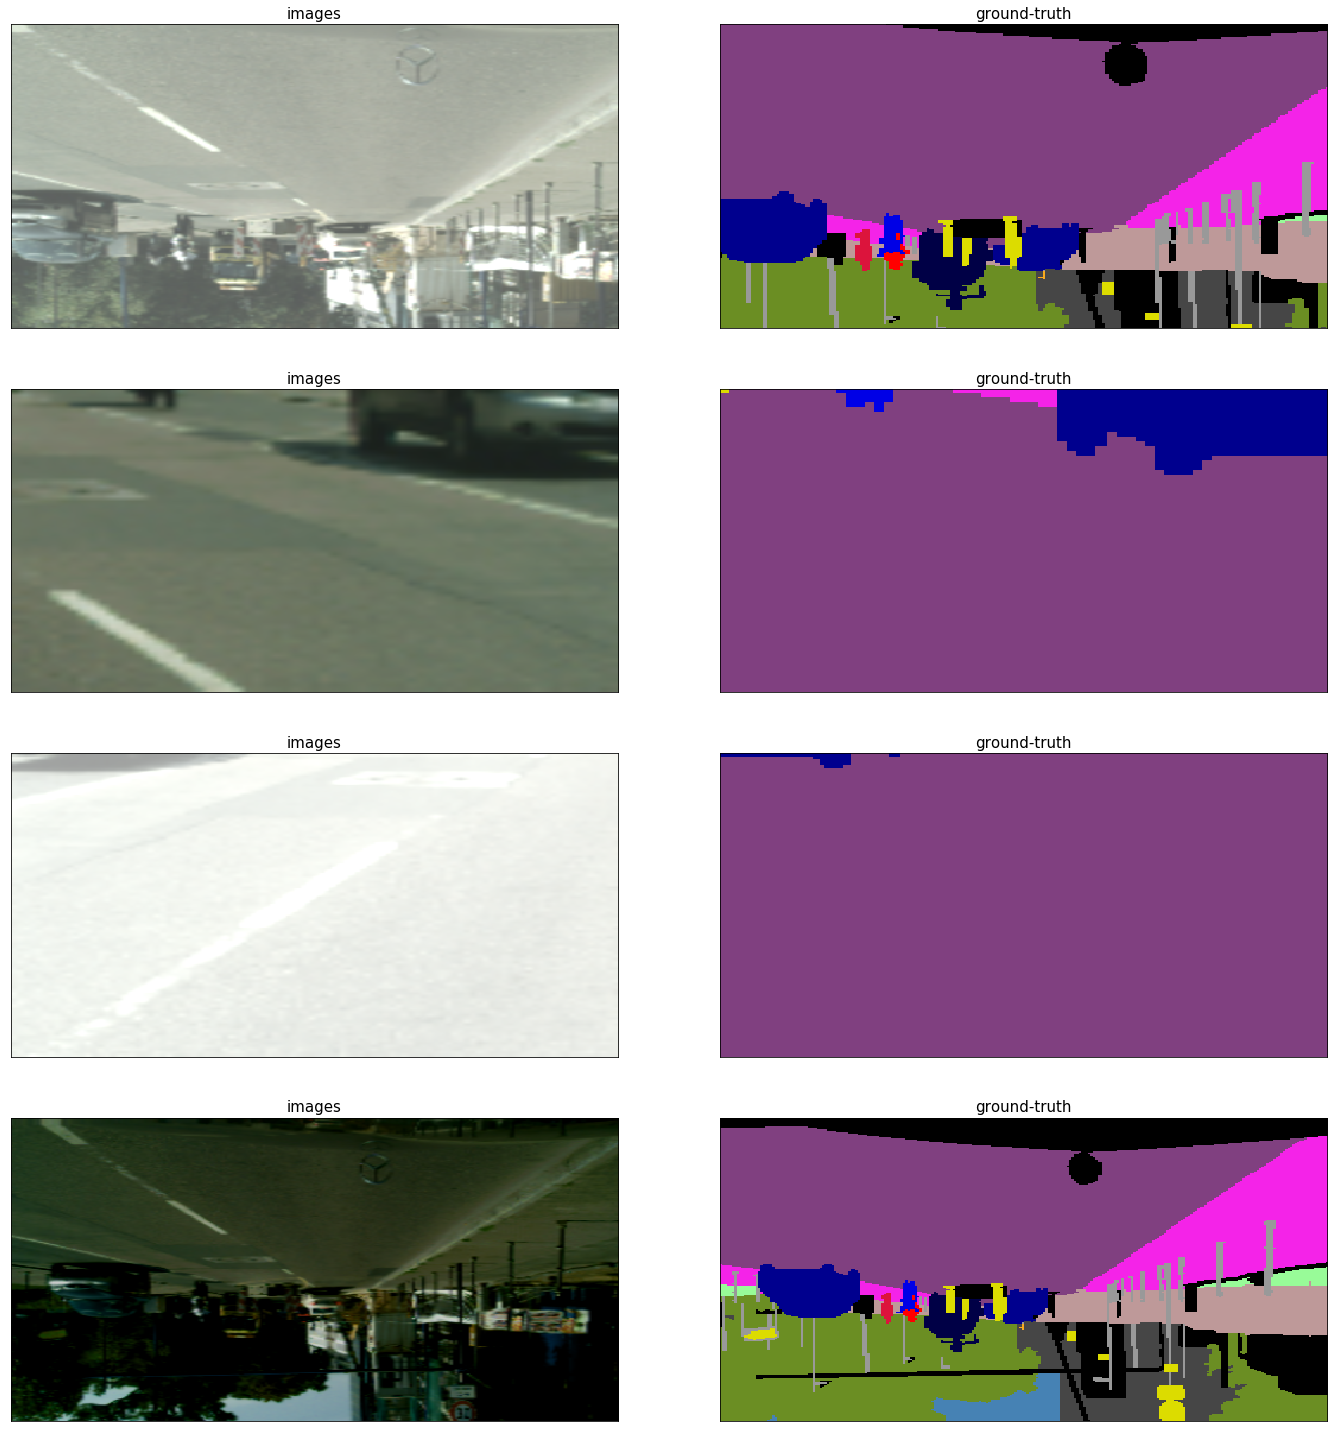

In [23]:
# Adding augmentation to our dataset:
aug_fn = functools.partial(augmentation_function,
                           crop_min_factor=0.1, flip_left_right=True, flip_up_down=True,
                           brightness_max_delta=.8, saturation_max_delta=.8)
dataset_aug = dataset_image.map(aug_fn)

# Show:
show_dataset_samples(dataset_aug, num_show=4)

... but this is no good. Those augmentations are definitely not appropriate for our training scenerio: we have no reason to train our segmentation models on upside-down images, on too-zoomed-in images, or on artificially too bright/dark ones, etc. 

As explained in the book, augmentation operations should be picked and parametrized with care. Let us do better:

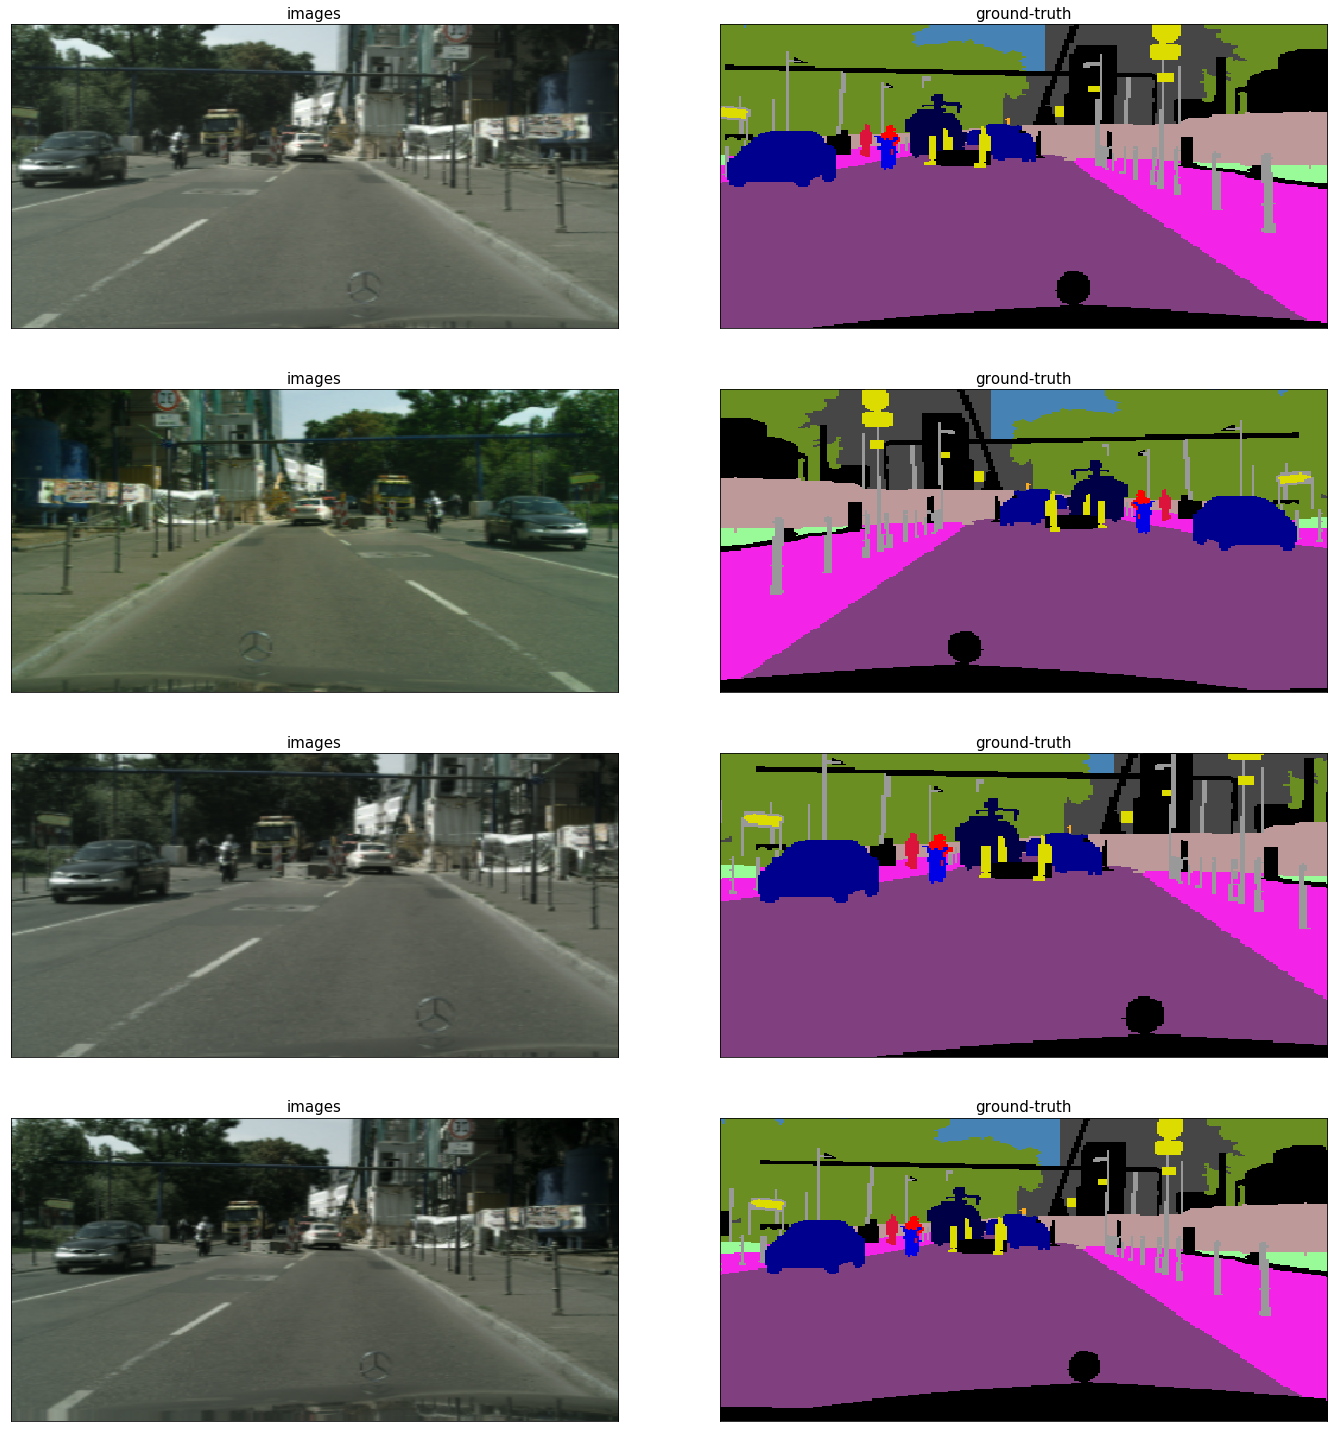

In [24]:
# Adding **proper** augmentation to our dataset:
aug_fn = functools.partial(augmentation_function,
                           crop_min_factor=0.8, flip_left_right=True, flip_up_down=False,
                           brightness_max_delta=.2, saturation_max_delta=.5)
dataset_aug = dataset_image.map(aug_fn)

# Show:
show_dataset_samples(dataset_aug, num_show=4)

Those transformations lead to much more realistic results, while still significantly editing the images.

### Loading Data

The last step of ETL pipeline is straightforward with `tf.data`. The ***loading*** of the data onto the target devices is automatically taken care of; and as we saw already, we can directly iterate over the dataset objects to obtain their processed samples.

As we saw in previous notebooks, these datasets can directly be passed to Keras models or TensorFlow estimators for their training.

## Optimizing Input Pipelines

In the second part of this notebook, we will illustrate some of the optimization schemes presented in the book, with the goal to build input pipelines able to efficiently serve training samples (i.e., to optimize training times).

### Monitoring Pipelines

To optimize systems, we need first to monitor their behavior. The TensorFlow team recently introduced such monitoring for `tf.data.Dataset` instances, allowing to evaluate the latency caused by each of their operations, the number of bytes flowing through the pipelines, etc.

To aggregate and visualize these statistics, one should just assign a `tf.data.experimental.StatsAggregator` instance to a dataset, and the `StatsAggregator` will take care of collecting the statistics and return them as `Summary` elements. However, at the time this notebook was written, those functionalities are not fully implemented for TensorFlow 2. Nevertheless, we will demonstrate as far as we can how one can use these features:

In [25]:
dataset = dataset_aug

# Aggregator instance which will collect the stats and provide the corresponding summaries:
stats_aggregator = tf.data.experimental.StatsAggregator()

# Apply `StatsOptions` to associate `dataset` with `aggregator`.
options = tf.data.Options()
options.experimental_stats.aggregator = stats_aggregator
options.experimental_stats.prefix = "dataset_stats/" # Prefix for summaries' tags
options.experimental_stats.latency_all_edges = True # set to True to have more detailed stats

# Stats operations can also be applied to a dataset as follows:
# dataset = dataset.apply(tf.data.experimental.latency_stats("total_bytes"))

dataset = dataset.with_options(options)
summary_writer = tf.summary.create_file_writer('./summaries')

with summary_writer.as_default():
    # Once fully implemented, `StatsAggregator` should be able to log the
    # stats summaries by itself. For now, we will just print its summaries:
    
    # To create some stats, we iterate a bit over our dataset:
    for batch in dataset.take(100):
        continue # iterate over 100 batches
    stats_summary = stats_aggregator.get_summary()
    
    # We display the stats:
    stats_summary_readable = tf.compat.v1.Summary().FromString(stats_summary.numpy())
    print(stats_summary_readable)

value {
  tag: "dataset_stats/_record_latency_TakeDataset/_8"
  histo {
    min: 16513.0
    max: 54673.0
    num: 100.0
    sum: 2275435.0
    sum_squares: 55108803153.0
    bucket_limit: 15294.66245802546
    bucket_limit: 16824.128703828006
    bucket_limit: 18506.54157421081
    bucket_limit: 20357.19573163189
    bucket_limit: 22392.915304795082
    bucket_limit: 24632.206835274592
    bucket_limit: 27095.427518802055
    bucket_limit: 29804.97027068226
    bucket_limit: 32785.46729775049
    bucket_limit: 36064.01402752554
    bucket_limit: 39670.415430278095
    bucket_limit: 43637.45697330591
    bucket_limit: 52801.32293770016
    bucket_limit: 58081.45523147019
    bucket_limit: 1.7976931348623157e+308
    bucket: 0.0
    bucket: 2.0
    bucket: 20.0
    bucket: 20.0
    bucket: 20.0
    bucket: 10.0
    bucket: 9.0
    bucket: 9.0
    bucket: 6.0
    bucket: 1.0
    bucket: 1.0
    bucket: 1.0
    bucket: 0.0
    bucket: 1.0
    bucket: 0.0
  }
}
value {
  tag: "dataset_stat

As we can see, our `StatsAggregator` does return latency statistics as `Summaries`, for all the operations our pipeline is composed of. These values are (_would_ - probabily in the next TF 2 release) logged and can be monitored on Tensorboard.

### Parallelizing and Tuning Pipelines

We will now detail some optimization options provided by TensorFlow.

In order to have more concise stats to compare the latency of the different pipelines we will instantiate, we will use a simpler timer function:

In [27]:
from timeit import default_timer as timer
import time
import matplotlib.pyplot as plt

def measure_input_pipeline_perf(dataset, num_iterations=20):
    print("Dataset performance test: \033[92mstart\033[0m.")
    t_begin = timer()
    process_times = []
    for img, gt in dataset:
        t_end = timer()
        process_times.append(t_end - t_begin)
        t_begin = t_end
        num_iterations -= 1
        if num_iterations == 0:
            break

    print("Dataset performance test: \033[91mend\033[0m.")
    return process_times

Let us check first the latency of our default pipeline:

In [28]:
time_comparison = []

dataset_aug = dataset.batch(batch_size)
process_times = measure_input_pipeline_perf(dataset_aug)
time_comparison.append(process_times)

print('Time per batch ({} images): \033[94m{:4.2f}s\033[0m'.format(
    batch_size, np.mean(process_times)))

Dataset performance test: start.
Dataset performance test: end.
Time per batch (32 images): 0.71s


Now, a first easy way to improve the streaming performance is to ***parallelize*** the heavy operations, taking advantage of the multiple CPUs most machines have. `.map(fn)` operations can be parallelized by changing the value of the parameter `num_parallel_calls`. For example:

In [29]:
dataset_image = dataset_file.map(parse_fn, num_parallel_calls=4)
dataset_aug = dataset_image.map(aug_fn, num_parallel_calls=4)
dataset_aug = dataset_aug.batch(batch_size)

process_times = measure_input_pipeline_perf(dataset_aug)
time_comparison.append(process_times)

print('Time per batch ({} images): \033[94m{:4.2f}s\033[0m'.format(
    batch_size, np.mean(process_times)))

Dataset performance test: start.
Dataset performance test: end.
Time per batch (32 images): 0.34s


Quite an improvement already!

Note that parallelization can be further taken advantage of by asking the input pipelines to ***prefetch*** the next samples/batches, while the rest of the system uses the current batch (e.g., while the batch is fed to the model for training):

In [30]:
dataset_aug = dataset_aug.prefetch(1) # asking to start preparing the 1 next batch each iteration

Finally, one of the key, recent, features of the `tf.data` API is its ability to automatically optimize the input pipelines, by combining mapping/batching operations (c.f. Chapter 7), auto-tuning the number of parallel threads, etc.

These optimizations are still experimental, and should therefore be manually activated:

In [31]:
dataset_image = dataset_file.map(parse_fn)
dataset_aug = dataset_image.map(aug_fn)
dataset_aug = dataset_aug.batch(batch_size)

options = tf.data.Options()
options.experimental_optimization.map_and_batch_fusion = True
options.experimental_optimization.map_fusion = True
options.experimental_optimization.map_parallelization = True
# options.experimental_optimization.map_vectorization = True
options.experimental_optimization.noop_elimination = True
options.experimental_optimization.apply_default_optimizations = True
options.experimental_autotune = True
dataset_aug = dataset_aug.with_options(options)

process_times = measure_input_pipeline_perf(dataset_aug)
time_comparison.append(process_times)

print('Time per batch ({} images): \033[94m{:4.2f}s\033[0m'.format(
    batch_size, np.mean(process_times)))

Dataset performance test: start.
Dataset performance test: end.
Time per batch (32 images): 0.31s


This further improved the performance of our parallelized pipeline by ~10%! If we compare the three versions of our data iterator:

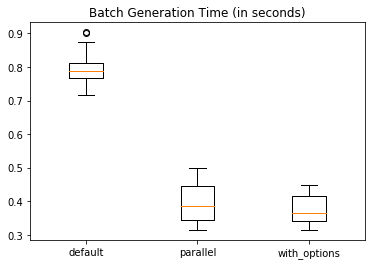

In [18]:
import pylab

fig, ax = plt.subplots()
ax.set_title('Batch Generation Time (in seconds)')
bp = ax.boxplot(time_comparison)
pylab.xticks([1,2,3], ['default', 'parallel', 'with_options'])
plt.show()

### Conclusion

Though most of the features we just covered are still experimental, the visibility and performance boost they provide can be crucial to many applications, like the training of advanced models on large/complex datasets.

<a id="ref"></a>
#### References

1. Cordts, M., Omran, M., Ramos, S., Rehfeld, T., Enzweiler, M., Benenson, R., Franke, U., Roth, S., Schiele, B., 2016. The Cityscapes Dataset for Semantic Urban Scene Understanding. In: 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR). Presented at the 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), IEEE, Las Vegas, NV, USA, pp. 3213–3223.